<a href="https://colab.research.google.com/github/Varun-Gupta304/ETL-pipeline/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the essentials

In [2]:
!pip install torch torchvision torchaudio
!pip install scikit-image
!pip install opencv-python
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install tqdm
!pip install pillow

In [101]:
!wget https://raw.githubusercontent.com/souravs17031999/Retinal_blindness_detection_Pytorch/refs/heads/master/model.py


--2025-09-07 12:13:09--  https://raw.githubusercontent.com/souravs17031999/Retinal_blindness_detection_Pytorch/refs/heads/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3547 (3.5K) [text/plain]
Saving to: ‘model.py.1’

model.py.1          100%[===================>]   3.46K  --.-KB/s    in 0s      

2025-09-07 12:13:09 (43.0 MB/s) - ‘model.py.1’ saved [3547/3547]



In [28]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os

# Set your base directory in Colab
base_dir = "/content/Retinal_blindness_detection_Pytorch/sampleimages"

# Check if the path exists
if os.path.exists(base_dir):
    print("✅ Path exists:", base_dir)
    print("📂 Files inside:", os.listdir(base_dir)[:10])  # show first 10 files
else:
    print("❌ Path not found! Please check if you uploaded/unzipped the dataset.")


✅ Path exists: /content/Retinal_blindness_detection_Pytorch/sampleimages
📂 Files inside: ['eye1.png', 'eye14.jpg', 'eye13.jpg', 'eye11.png', 'eye20.png', 'eye16.png', 'eye19.png', 'eye9.jpg', 'eye6.jpg', 'eye2.png']


In [29]:
print(os.listdir("/content/Retinal_blindness_detection_Pytorch/sampleimages"))


['eye1.png', 'eye14.jpg', 'eye13.jpg', 'eye11.png', 'eye20.png', 'eye16.png', 'eye19.png', 'eye9.jpg', 'eye6.jpg', 'eye2.png', 'eye10.jpg', 'eye4.jpg', 'eye17.png', 'eye8.jpg', 'eye5.jpg', 'eye15.jpg', 'eye12.jpg', 'eye18.png', 'eye7.jpg', 'eye3.png']


In [10]:
import seaborn as sns

# Loading Data + EDA

In [12]:
train_csv = pd.read_csv('/content/messidor_data.csv')
test_csv = pd.read_csv('/content/train.csv')

In [93]:
import os

base_dir = "/content/Retinal_blindness_detection_Pytorch/sampleimages"
image_files = sorted(os.listdir(base_dir))

# Limit CSV to first 20 rows
train_csv = train_csv.iloc[:len(image_files)].copy()
train_csv['id_code'] = image_files  # assign the 20 filenames


In [13]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 1744
Public Test Size = 3662


In [14]:
train_csv.head()

,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


/tmp/ipython-input-4270284725.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='diagnosis', y='count', data=counts_df, alpha=0.8, palette='bright')


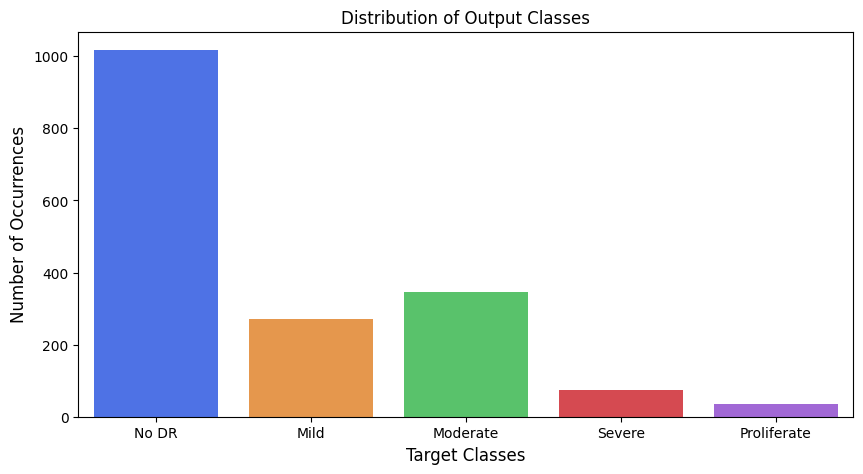

In [16]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
# sns.barplot(counts.index, counts.values, alpha=0.8, palette='bright') # Original line causing error

# Create a DataFrame from the counts series with appropriate column names
counts_df = pd.DataFrame({'diagnosis': counts.index, 'count': counts.values})
sns.barplot(x='diagnosis', y='count', data=counts_df, alpha=0.8, palette='bright')

plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

# Visualizing Training Data

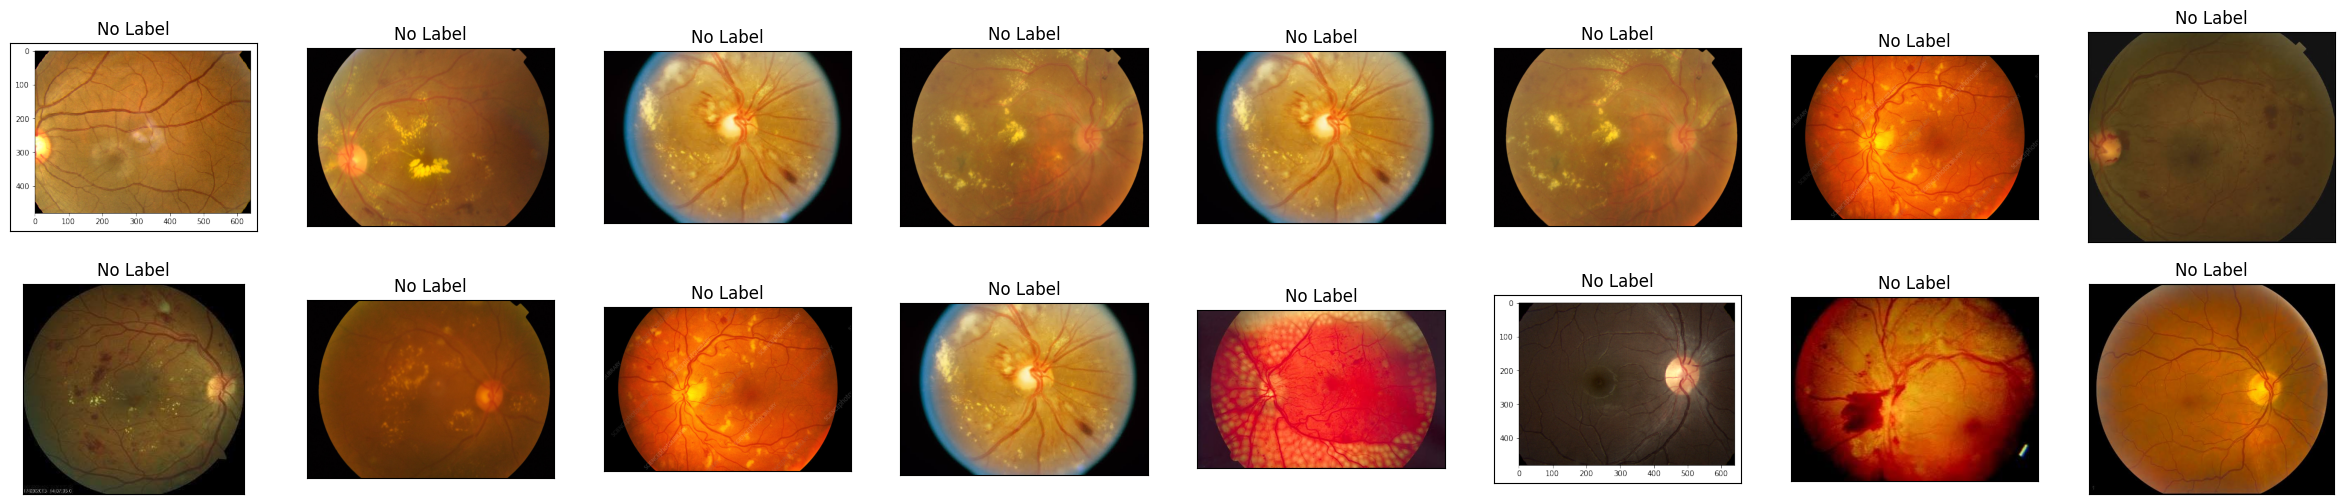

In [32]:
fig = plt.figure(figsize=(30, 6))

train_imgs = os.listdir(base_dir)   # base_dir = "/content/Retinal_blindness_detection_Pytorch/sampleimages"

for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, img))
    plt.imshow(im)

    # get id without extension
    img_id = img.split('.')[0]

    # check if this id exists in train_csv
    row = train_csv.loc[train_csv['id_code'] == img_id, 'diagnosis']
    if not row.empty:
        lab = row.values[0]
        ax.set_title(f'Severity: {lab}')
    else:
        ax.set_title("No Label")  # fallback if label not found


# Visualizing Test Set

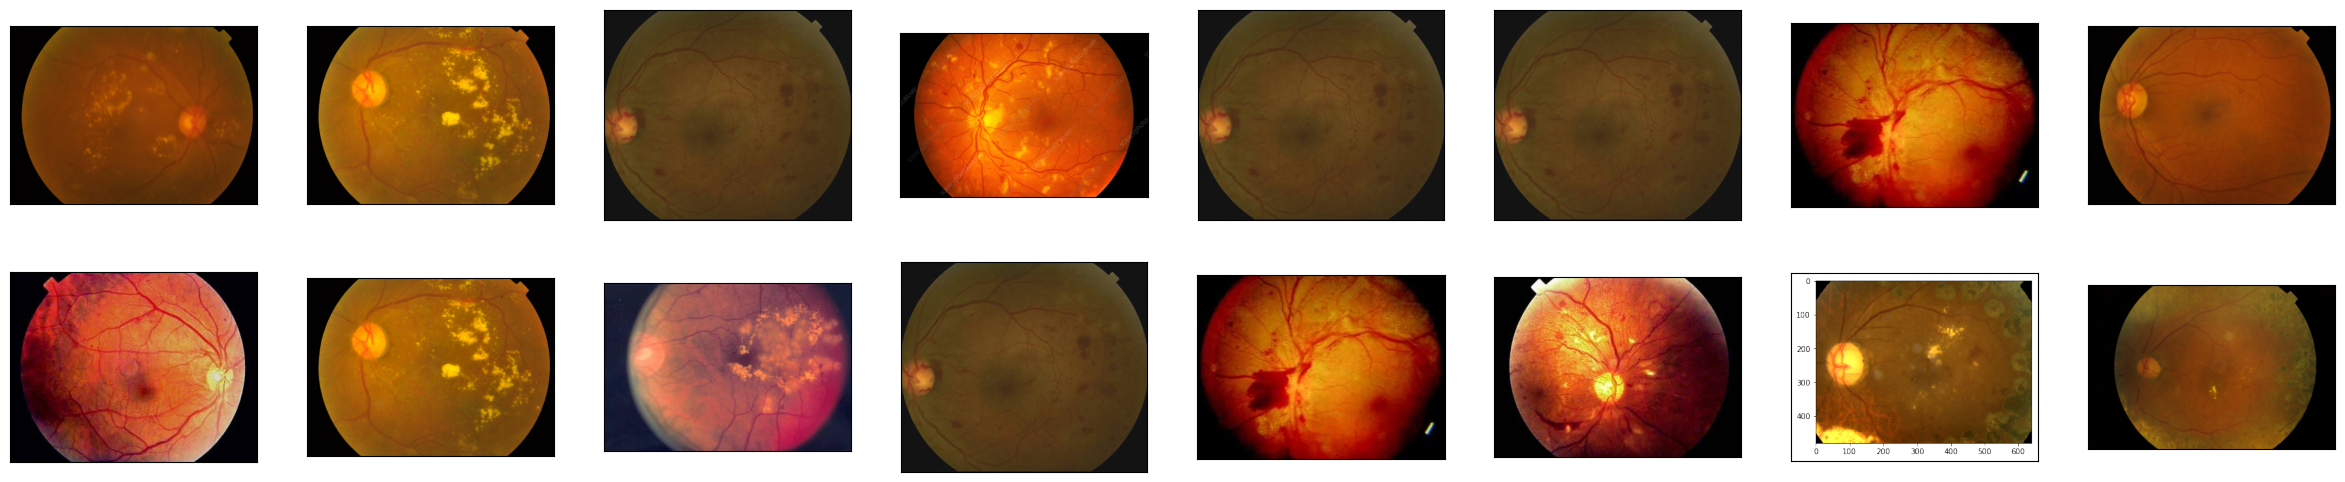

In [34]:
fig = plt.figure(figsize=(30, 6))

# list images directly from sampleimages
test_imgs = os.listdir(base_dir)   # base_dir = "/content/Retinal_blindness_detection_Pytorch/sampleimages"

# pick 16 random images
for idx, img in enumerate(np.random.choice(test_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, img))   # safer path join
    plt.imshow(im)


# Data Processing

In [35]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [36]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [37]:
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [38]:
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [39]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)


In [40]:
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [41]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [42]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [43]:
print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 1744
testing examples contain : 3662
22
6
58


In [45]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class RetinalDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): must contain 'id_code' and 'diagnosis' columns
            data_dir (str): path to folder with images
            transform (callable, optional): torchvision transforms to apply
        """
        self.df = dataframe.reset_index(drop=True)  # ensure clean indexing
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # get one row
        row = self.df.iloc[index]

        # image name and label
        img_name = row['id_code']
        label = int(row['diagnosis'])   # make sure it's an integer

        # full path (adjust extension if not .png)
        img_path = os.path.join(self.data_dir, img_name + '.png')

        # read image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB

        # apply transform if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [86]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RetinopathyDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        """
        dataframe: pd.DataFrame with columns 'id_code' and 'diagnosis'
        data_dir: folder containing images
        transform: torchvision transforms
        """
        self.df = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_name = row['id_code']
        label = int(row['diagnosis'])

        # check if CSV id already has extension
        img_path = os.path.join(self.data_dir, img_name)
        if not os.path.exists(img_path):
            # try adding common extensions
            found = False
            for ext in ['.png', '.jpg', '.jpeg']:
                potential_path = os.path.join(self.data_dir, img_name + ext)
                if os.path.exists(potential_path):
                    img_path = potential_path
                    found = True
                    break
            if not found:
                raise FileNotFoundError(f"No image found for {img_name} in {self.data_dir}")

        # read and convert
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label


# Example transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Create dataset and loader
train_dataset = RetinopathyDataset(train_csv, base_dir, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [56]:
import os
print(base_dir)
print(os.listdir(base_dir)[:10])  # show first 10 files


/content/Retinal_blindness_detection_Pytorch/sampleimages
['eye1.png', 'eye14.jpg', 'eye13.jpg', 'eye11.png', 'eye20.png', 'eye16.png', 'eye19.png', 'eye9.jpg', 'eye6.jpg', 'eye2.png']


In [57]:
train_dataset = RetinopathyDataset(train_csv, base_dir, transform=transform)


In [79]:
# Create dataset instance
dataset = RetinalDataset(train_csv, base_dir, transform=transform)

# Get the first row's image name
img_name = train_csv.iloc[0]['id_code']

# Use base_dir directly instead of self
img_path = os.path.join(base_dir, img_name + '.png')  # or '.jpg' if your images are JPG
print(img_path)




/content/Retinal_blindness_detection_Pytorch/sampleimages/20051020_43808_0100_PP.png.png


In [88]:
import os

print("Base directory:", base_dir)
print("Files in base_dir (first 20):", os.listdir(base_dir)[:20])


Base directory: /content/Retinal_blindness_detection_Pytorch/sampleimages
Files in base_dir (first 20): ['eye1.png', 'eye14.jpg', 'eye13.jpg', 'eye11.png', 'eye20.png', 'eye16.png', 'eye19.png', 'eye9.jpg', 'eye6.jpg', 'eye2.png', 'eye10.jpg', 'eye4.jpg', 'eye17.png', 'eye8.jpg', 'eye5.jpg', 'eye15.jpg', 'eye12.jpg', 'eye18.png', 'eye7.jpg', 'eye3.png']


In [89]:
print(train_csv['id_code'].head(10))


0    20051020_43808_0100_PP.png
1    20051020_43832_0100_PP.png
2    20051020_43882_0100_PP.png
3    20051020_43906_0100_PP.png
4    20051020_44261_0100_PP.png
5    20051020_44284_0100_PP.png
6    20051020_44338_0100_PP.png
7    20051020_44349_0100_PP.png
8    20051020_44400_0100_PP.png
9    20051020_44431_0100_PP.png
Name: id_code, dtype: object


In [95]:
# Limit CSV to the number of images you actually have
import os

base_dir = "/content/Retinal_blindness_detection_Pytorch/sampleimages"
image_files = sorted(os.listdir(base_dir))  # ['eye1.png', 'eye2.png', ...]
train_csv = train_csv.iloc[:len(image_files)].copy()
train_csv['id_code'] = image_files  # assign the actual filenames

# Now create your Dataset
train_dataset = RetinopathyDataset(train_csv, base_dir, transform=transform)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [83]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=True)

num_ftrs = model.fc.in_features
out_ftrs = 5
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

In [96]:
model_save_name = 'classifier.pt'
path = F"/kaggle/working/{model_save_name}"

In [97]:
# to unfreeze more layers
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [98]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [99]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [100]:
model = load_model("../input/kernel4f121f3247/classifier.pt")

FileNotFoundError: [Errno 2] No such file or directory: '../input/kernel4f121f3247/classifier.pt'

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
58970117


In [ ]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses, acc = [] , [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 10 == 0:
            print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        print(f"validation started for {epoch + 1}")
        model.eval()
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images)
          test_loss += criterion(logps,labels)
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      acc.append(accuracy)
      scheduler.step()
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train()
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader)))
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)
    print('Training Completed Succesfully !')
    return train_losses, test_losses, acc

In [ ]:
train_losses, valid_losses, acc = train_and_test(5)

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
validation started for 1
Epoch: 1/5..  Training Loss: 0.138..  Valid Loss: 0.115..  Valid Accuracy: 0.958
Validation loss decreased (inf --> 0.114695).  Saving model ...


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site

 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
validation started for 2
Epoch: 2/5..  Training Loss: 0.092..  Valid Loss: 0.122..  Valid Accuracy: 0.960
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
validation started for 3
Epoch: 3/5..  Training Loss: 0.081..  Valid Loss: 0.113..  Valid Accuracy: 0.964
Validation loss decreased (0.114695 --> 0.113338).  Saving model ...
 epoch 4 batch 10 completed
 epoch 4 batch 20 completed
 epoch 4 batch 30 completed
 epoch 4 batch 40 completed
validation started for 4
Epoch: 4/5..  Training Loss: 0.079..  Valid Loss: 0.120..  Valid Accuracy: 0.962
 epoch 5 batch 10 completed
 epoch 5 batch 20 completed
 epoch 5 batch 30 completed
 epoch 5 batch 40 completed
validation started for 5
Epoch: 5/5..  Training Loss: 0.073..  Valid Loss: 0.107..  Valid Accuracy: 0.967
Validation loss decreased (0.113338 --> 0.106542).  Saving 

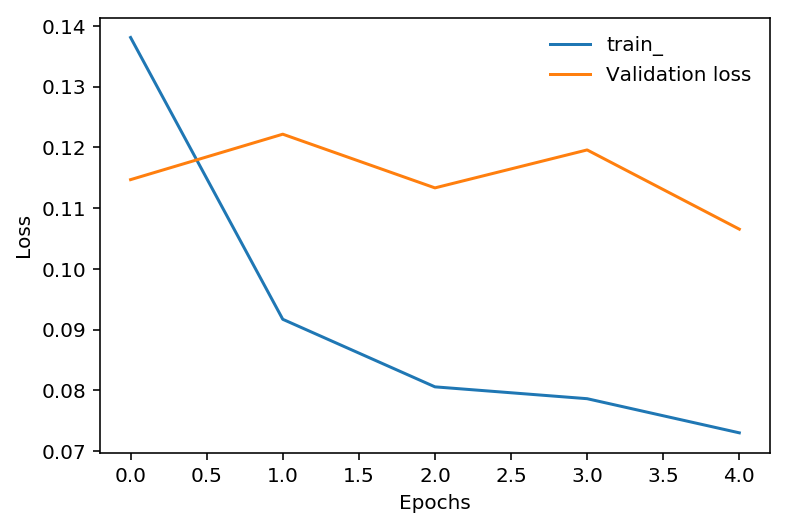

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='train_')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

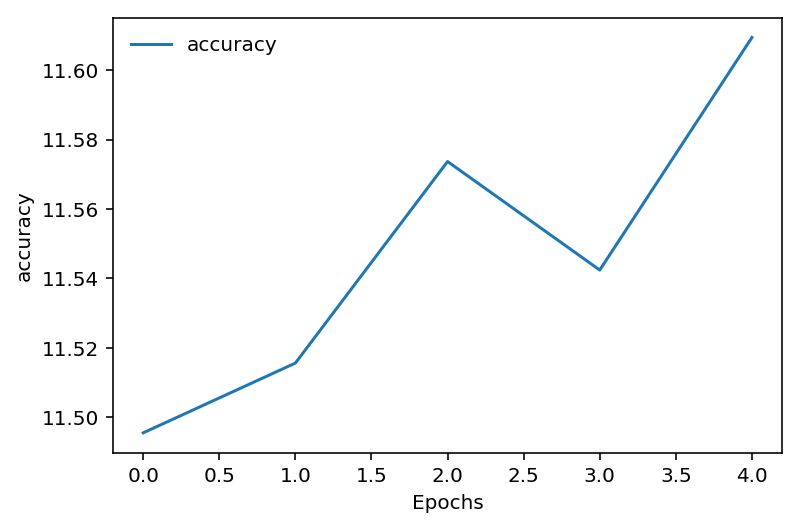

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(acc, label='accuracy')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(frameon=False)